In [2]:
from langchain_ollama import ChatOllama

local_llm = "llama3.2:3b"
llm = ChatOllama(model=local_llm, temperature=0)
llm_json_mode = ChatOllama(model=local_llm, temperature=0, format="json")

In [3]:
import os, getpass


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("TAVILY_API_KEY")
os.environ["TOKENIZERS_PARALLELISM"] = "true"

In [8]:
from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(k=3)

In [4]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import SKLearnVectorStore
from langchain_nomic.embeddings import NomicEmbeddings

urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

# Load documents
docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

# Split documents
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=1000, chunk_overlap=200
)
doc_splits = text_splitter.split_documents(docs_list)

# Add to vectorDB
vectorstore = SKLearnVectorStore.from_documents(
    documents=doc_splits,
    embedding=NomicEmbeddings(model="nomic-embed-text-v1.5", inference_mode="local"),
)

# Create retriever
retriever = vectorstore.as_retriever(k=3)

USER_AGENT environment variable not set, consider setting it to identify your requests.
Downloading: 100%|██████████| 274M/274M [03:15<00:00, 1.40MiB/s] 
Verifying: 100%|██████████| 274M/274M [00:00<00:00, 547MiB/s] 


## Creating a LangChain Graph

In [16]:
import operator
from typing_extensions import TypedDict
from typing import List, Annotated


class GraphState(TypedDict):
    """dictionary that contains information we want to propagate to, and modify in, each graph node."""

    question: str  # User question
    documents: List[str]  # List of retrieved documents from vector store or web search
    generation: str  # LLM generation
    web_search: str  # Binary decision to run web search
    max_retries: int  # Max number of retries for answer generation
    answers: int  # Number of answers generated
    loop_step: Annotated[int, operator.add]

### Prompt Instructions

In [17]:
router_instructions = """You are an expert at routing a user question to a vectorstore or web search.
The vectorstore contains documents related to agents, prompt engineering, and adversarial attacks.                    
Use the vectorstore for questions on these topics. For all else, and especially for current events, use web-search.
Return JSON with single key, datasource, that is 'websearch' or 'vectorstore' depending on the question."""

doc_grader_instructions = """You are a grader assessing relevance of a retrieved document to a user question.
If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant."""

doc_grader_prompt = """Here is the retrieved document: \n\n {document} \n\n Here is the user question: \n\n {question}. 
This carefully and objectively assess whether the document contains at least some information that is relevant to the question.
Return JSON with single key, binary_score, that is 'yes' or 'no' score to indicate whether the document contains at least some information that is relevant to the question."""

rag_prompt = """You are an assistant for question-answering tasks. 
Here is the context to use to answer the question:
{context} 
Think carefully about the above context. 
Now, review the user question:
{question}
Provide an answer to this questions using only the above context. 
Use three sentences maximum and keep the answer concise.
Answer:"""

hallucination_grader_instructions = """
You are a teacher grading a quiz. 
You will be given FACTS and a STUDENT ANSWER. 
Here is the grade criteria to follow:
(1) Ensure the STUDENT ANSWER is grounded in the FACTS. 
(2) Ensure the STUDENT ANSWER does not contain "hallucinated" information outside the scope of the FACTS.

Score:
A score of yes means that the student's answer meets all of the criteria. This is the highest (best) score. 
A score of no means that the student's answer does not meet all of the criteria. This is the lowest possible score you can give.
Explain your reasoning in a step-by-step manner to ensure your reasoning and conclusion are correct. 
Avoid simply stating the correct answer at the outset."""

# Grader prompt
hallucination_grader_prompt = """FACTS: \n\n {documents} \n\n STUDENT ANSWER: {generation}.  
Return JSON with two two keys, binary_score is 'yes' or 'no' score to indicate whether the STUDENT ANSWER is grounded in the FACTS. And a key, explanation, that contains an explanation of the score."""

answer_grader_instructions = """You are a teacher grading a quiz. 
You will be given a QUESTION and a STUDENT ANSWER. 
Here is the grade criteria to follow:
(1) The STUDENT ANSWER helps to answer the QUESTION

Score:
A score of yes means that the student's answer meets all of the criteria. This is the highest (best) score. 
The student can receive a score of yes if the answer contains extra information that is not explicitly asked for in the question.
A score of no means that the student's answer does not meet all of the criteria. This is the lowest possible score you can give.
Explain your reasoning in a step-by-step manner to ensure your reasoning and conclusion are correct. 
Avoid simply stating the correct answer at the outset."""

answer_grader_prompt = """QUESTION: \n\n {question} \n\n STUDENT ANSWER: {generation}. 
Return JSON with two two keys, binary_score is 'yes' or 'no' score to indicate whether the STUDENT ANSWER meets the criteria. And a key, explanation, that contains an explanation of the score."""

### Langchain nodes

In [18]:
import json
from langchain.schema import Document
from langgraph.graph import END
from langchain_core.messages import HumanMessage, SystemMessage


def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


def route_question(state):
    """Route question to web search or RAG"""

    print("---ROUTE QUESTION---")
    route_question = llm_json_mode.invoke(
        [SystemMessage(content=router_instructions)]
        + [HumanMessage(content=state["question"])]
    )
    source = json.loads(route_question.content)["datasource"]
    if source == "websearch":
        print("---ROUTE QUESTION TO WEB SEARCH---")
        return "websearch"
    elif source == "vectorstore":
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"


# Retrive documents from vector store
def retrieve(state):
    print("---RETRIEVE---")
    question = state["question"]

    documents = retriever.invoke(question)
    return {"documents": documents}


# Grade retrieved documents from vector store
def grade_documents(state):
    """If any document is not relevant, we will set a flag to run web search"""

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    web_search = "No"
    for d in documents:
        doc_grader_prompt_formatted = doc_grader_prompt.format(
            document=d.page_content, question=question
        )
        result = llm_json_mode.invoke(
            [SystemMessage(content=doc_grader_instructions)]
            + [HumanMessage(content=doc_grader_prompt_formatted)]
        )
        grade = json.loads(result.content)["binary_score"]
        # Document relevant
        if grade.lower() == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        # Document not relevant
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            # We do not include the document in filtered_docs
            # We set a flag to indicate that we want to run web search
            web_search = "Yes"
            continue
    return {"documents": filtered_docs, "web_search": web_search}


def decide_to_generate(state):
    """Determines whether to generate an answer, or add web search"""

    print("---ASSESS GRADED DOCUMENTS---")
    question = state["question"]
    web_search = state["web_search"]
    filtered_documents = state["documents"]

    if web_search == "Yes":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: NOT ALL DOCUMENTS ARE RELEVANT TO QUESTION, INCLUDE WEB SEARCH---"
        )
        return "websearch"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"


def generate(state):
    """Generate answer using RAG on retrieved documents"""
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]
    loop_step = state.get("loop_step", 0)

    # RAG generation
    docs_txt = format_docs(documents)
    rag_prompt_formatted = rag_prompt.format(context=docs_txt, question=question)
    generation = llm.invoke([HumanMessage(content=rag_prompt_formatted)])
    return {"generation": generation, "loop_step": loop_step + 1}


# Web search based based on the question
def web_search(state):
    print("---WEB SEARCH---")
    question = state["question"]
    documents = state.get("documents", [])

    # Web search
    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)
    documents.append(web_results)
    return {"documents": documents}


def grade_generation_v_documents_and_question(state):
    """Determines whether the generation is grounded in the document and answers question"""

    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]
    max_retries = state.get("max_retries", 3)  # Default to 3 if not provided

    hallucination_grader_prompt_formatted = hallucination_grader_prompt.format(
        documents=format_docs(documents), generation=generation.content
    )
    result = llm_json_mode.invoke(
        [SystemMessage(content=hallucination_grader_instructions)]
        + [HumanMessage(content=hallucination_grader_prompt_formatted)]
    )
    grade = json.loads(result.content)["binary_score"]

    # Check hallucination
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # Check question-answering
        print("---GRADE GENERATION vs QUESTION---")
        # Test using question and generation from above
        answer_grader_prompt_formatted = answer_grader_prompt.format(
            question=question, generation=generation.content
        )
        result = llm_json_mode.invoke(
            [SystemMessage(content=answer_grader_instructions)]
            + [HumanMessage(content=answer_grader_prompt_formatted)]
        )
        grade = json.loads(result.content)["binary_score"]
        if grade == "yes":
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        elif state["loop_step"] <= max_retries:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
        else:
            print("---DECISION: MAX RETRIES REACHED---")
            return "max retries"
    elif state["loop_step"] <= max_retries:
        print("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"
    else:
        print("---DECISION: MAX RETRIES REACHED---")
        return "max retries"

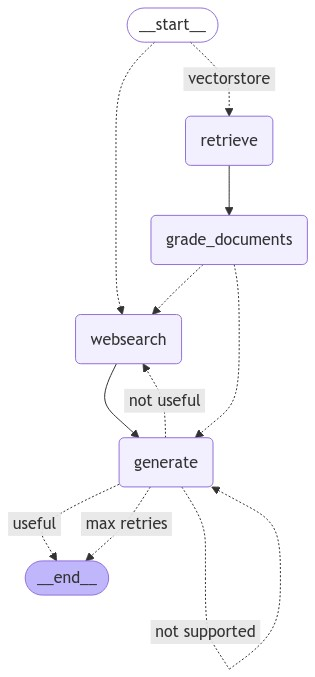

In [19]:
from langgraph.graph import StateGraph
from IPython.display import Image, display

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("websearch", web_search)  # web search
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generate

# Build graph
workflow.set_conditional_entry_point(
    route_question,
    {
        "websearch": "websearch",
        "vectorstore": "retrieve",
    },
)
workflow.add_edge("websearch", "generate")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "websearch": "websearch",
        "generate": "generate",
    },
)
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "websearch",
        "max retries": END,
    },
)

graph = workflow.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [20]:
inputs = {"question": "What are the types of agent memory?", "max_retries": 3}
for event in graph.stream(inputs, stream_mode="values"):

    print(event)

---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
{'question': 'What are the types of agent memory?', 'max_retries': 3, 'loop_step': 0}
---RETRIEVE---
{'question': 'What are the types of agent memory?', 'documents': [Document(metadata={'id': '55e566b6-9c04-4a28-8ea9-926cf9adeb1d', 'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview In a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:', 'language': 'en'}, page_content="LLM Powered Autonomous Agents | Lil'Log\n\n\n\n\n\n\n\n\n\

In [34]:
inputs = {
    "question": "What are the latest Llama models?",
    "max_retries": 3,
}

events = []

for event in graph.stream(inputs, stream_mode="values"):
    events.append(event)
    print(event)

---ROUTE QUESTION---
---ROUTE QUESTION TO WEB SEARCH---
{'question': 'What are the models released today for llama3.2?', 'max_retries': 3, 'loop_step': 0}
---WEB SEARCH---
{'question': 'What are the models released today for llama3.2?', 'documents': [Document(metadata={}, page_content="IBM is announcing the availability of multiple Llama 3.2 models on watsonx.ai, IBM's enterprise studio for AI developers, following the launch of the Llama 3.2 collection of pretrained and instruction tuned multilingual large language models (LLMs) at MetaConnect earlier today.. Most notably, Llama 3.2 marks Meta's first foray into multimodal AI: the release includes two models, in sizes ...\nIn July, we announced the addition of Meta's Llama 3.1 open models to Vertex AI Model Garden. Since then, developers and enterprises have shown tremendous enthusiasm for building with the Llama models. Today, we're announcing that Llama 3.2, Meta's new generation of multimodal models, is available on Vertex AI Model

In [35]:
events

[{'question': 'What are the models released today for llama3.2?',
  'max_retries': 3,
  'loop_step': 0},
 {'question': 'What are the models released today for llama3.2?',
  'documents': [Document(metadata={}, page_content="IBM is announcing the availability of multiple Llama 3.2 models on watsonx.ai, IBM's enterprise studio for AI developers, following the launch of the Llama 3.2 collection of pretrained and instruction tuned multilingual large language models (LLMs) at MetaConnect earlier today.. Most notably, Llama 3.2 marks Meta's first foray into multimodal AI: the release includes two models, in sizes ...\nIn July, we announced the addition of Meta's Llama 3.1 open models to Vertex AI Model Garden. Since then, developers and enterprises have shown tremendous enthusiasm for building with the Llama models. Today, we're announcing that Llama 3.2, Meta's new generation of multimodal models, is available on Vertex AI Model Garden.. Llama 3.2 is a new generation of vision and lightweigh

In [36]:
events[-1]["generation"]

AIMessage(content="According to the context, Llama 3.2 marks Meta's first foray into multimodal AI, with two models available in sizes released on IBM's enterprise studio for AI developers, watsonx.ai. Additionally, Meta announced that Llama 3.2 is a new generation of vision and lightweight models, including its first version of free AI models to have visual abilities.", additional_kwargs={}, response_metadata={'model': 'llama3.2:3b', 'created_at': '2024-09-27T15:46:51.367663Z', 'message': {'role': 'assistant', 'content': ''}, 'done_reason': 'stop', 'done': True, 'total_duration': 14298616959, 'load_duration': 115186250, 'prompt_eval_count': 474, 'prompt_eval_duration': 4158581000, 'eval_count': 78, 'eval_duration': 9849504000}, id='run-375a53cf-3946-4eca-8d95-d5d897f85d92-0', usage_metadata={'input_tokens': 474, 'output_tokens': 78, 'total_tokens': 552})